# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Доронин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

пусть 

$$\sigma(y^{(i)} g(x^{(i)}))=\frac{1}{1+\exp(-g(x^{(i)}) y^{(i)}))}$$

тогда
$$\frac{\partial L}{\partial w_i} = \frac{1}{N}\sum_{j=0}^N \frac{-\exp\{-g(x^{(j)}) y^{(j)}\} g_{w_i}'(x^{(j)})y^{(j)}}{1+\exp\{-g(x^{(j)})y^{(j)}\}}+\frac{1}{C}sign(w_i)
= \frac{1}{N}\sum_{j=0}^N \frac{-g_{w_i}'(x^{(j)})y^{(j)}}{1+\exp\{g(x^{(j)})y^{(j)}\}}+\frac{1}{C}sign(w_i)$$
если $g$ - линейна, то $g_{w_j}'(x^{(i)})=x_j^{(i)}$ и $g_{w_0}'(x^{(i)})=1$

## Имплементация (5 баллов)

In [113]:
# %%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch = 50):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.iter = 1
        self.w = np.array([])
        self.w0 = 1
        self.L_mean = np.array([])
        self.batch = batch

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        y[y != 1] = -1
        self.w = np.ones(X.shape[1])
        self.w0 = 1
        for i in range(self.max_epoch):
            batch = np.arange(X.shape[0])
            np.random.shuffle(batch)
            for i in range(int(X.shape[0] // self.batch)):
                index = batch[self.batch * i: self.batch * (i + 1)]
                X_it = X[index]
                y_it = y[index]
                self.__grad(X_it, y_it)
            self.iter += 1
            self.L_mean = np.append(self.L_mean, self.L_func(X, y))

    def __grad(self, X, y):
        gy = (np.sum(X * self.w, axis=1) + self.w0) * y
        _exp = np.exp(gy)
        _exp = y / (1 + _exp)
        dJ = -np.sum(X * _exp[:, np.newaxis], axis=0)
        dw0 = -np.sum(_exp)
        self.w = self.w - dJ * self.alpha / self.iter
        self.w0 = self.w0 - dw0 * self.alpha / self.iter
        self.w[self.w > 0] =\
        (self.w[self.w > 0]- self.alpha / (self.iter * self.C))\
            * (self.w[self.w > 0] - self.alpha / (self.iter * self.C) > 0)
        self.w[self.w < 0] =\
        (self.w[self.w < 0] + self.alpha / (self.iter * self.C))\
            * (self.w[self.w < 0] + self.alpha / (self.iter * self.C) < 0)


    def L_func(self, X, y):
        gy = (np.sum(X * self.w, axis=1) + self.w0) * y
        sigma = 1. + np.exp(gy)
        log_s = np.log(sigma)
        L = np.sum(log_s) / X.shape[0] + np.sum(np.abs(self.w)) / self.C
        return L

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = (np.sum(X * self.w, axis=1) + self.w0 > 0) * 1\
            - (np.sum(X * self.w, axis=1) + self.w0 < 0) * 1
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        g = np.sum(X * self.w, axis=1) + self.w0
        g = g / np.linalg.norm([self.w, self.w0])
        y_hat_proba = 1. / (1 + np.exp(g))
        return y_hat_proba


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

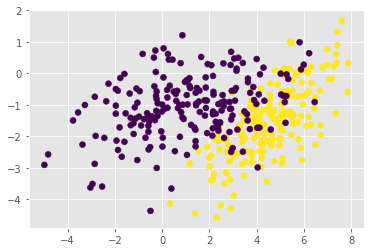

In [59]:
np.random.seed(0)
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)
X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [60]:
glc = MySGDClassifier(C=1, alpha=0.01, max_epoch=100)
glc.fit(X,y)

w1=0.49123630444665384  w2=-0.1597260100833816  w0=-1.2933529962721022
score is 0.82


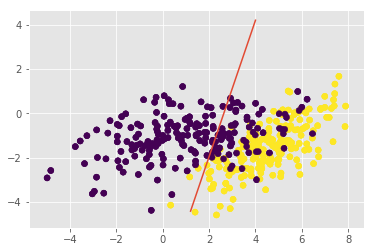

In [61]:
plt.scatter(X[:, 0], X[:, 1], c=y)
x_plt = (np.arange(15) + 6) * 0.2
y_plt = (-glc.w0 - glc.w[0] * x_plt) / glc.w[1]
plt.plot(x_plt, y_plt)
print(("w1=%s  w2=%s  w0=%s") % (glc.w[0], glc.w[1], glc.w0))
plt.scatter(X[:, 0], X[:, 1], c=y)
print(("score is %s") % (accuracy_score(glc.predict(X), y)))

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [136]:
from sklearn.datasets import make_classification

In [137]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [138]:
## Your Code Here
glc = MySGDClassifier(max_epoch=1000, batch=500)
glc.fit(X,y)

Text(0.5,1,'alpha=0.01')

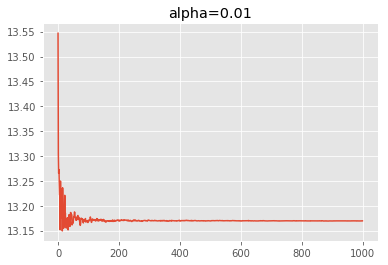

In [139]:
x_ = [i for i in range(glc.iter-1)]
y_ = glc.L_mean
plt.plot(x_,y_)
plt.title("alpha=0.01")

In [140]:
glc = MySGDClassifier(max_epoch=1000, batch=500, alpha=0.1)
glc.fit(X,y)

Text(0.5,1,'alpha=0.1')

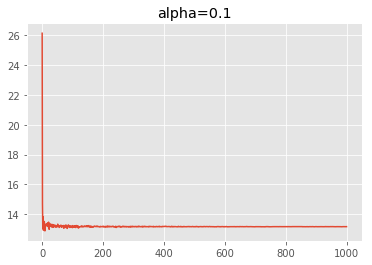

In [141]:
x_ = [i for i in range(glc.iter-1)]
y_ = glc.L_mean
plt.plot(x_,y_)
plt.title("alpha=0.1")

/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in exp


Text(0.5,1,'alpha=1')

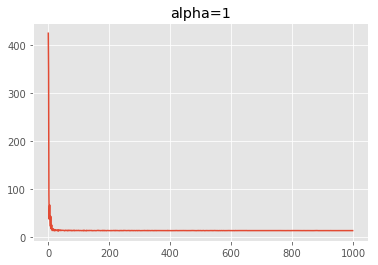

In [145]:
glc = MySGDClassifier(max_epoch=1000, batch=500, alpha=1)
glc.fit(X,y)
x_ = [i for i in range(glc.iter-1)]
y_ = glc.L_mean
plt.plot(x_,y_)
plt.title("alpha=1")

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [147]:
## Your Code Here
w_0 = []
w_1 = []
w_2 = []
for c in np.logspace(3, -3, 10):
    clf = MySGDClassifier(C = c, max_epoch=100, batch = 500)
    clf.fit(X,y)
    w_0.append(clf.w0)
    w_1.append(clf.w[0])
    w_2.append(clf.w[1])

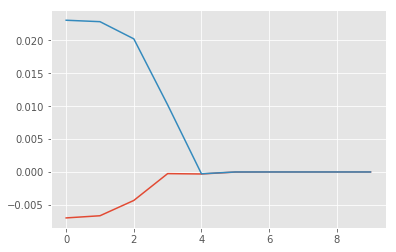

In [150]:
x_arg = np.logspace(3, -3, 10)
plt.plot(range(len(x_arg)), w_1, range(len(x_arg)), w_2)

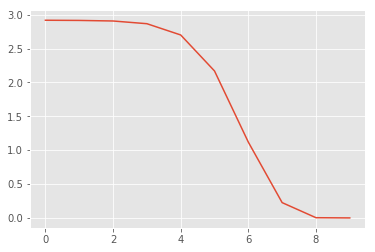

In [149]:
plt.plot(range(len(x_arg)), w_0)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [151]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [152]:
df_data.shape

(500000, 45)

In [153]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [154]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [155]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [156]:
## Youd Code Here
print("Player has", df_data['player_hero_card_id'].unique().shape[0], "unique cards")
print("Opponent has" , df_data['opponent_hero_card_id'].unique().shape[0], "unique cards")

Player has 9 unique cards
Opponent has 9 unique cards


In [157]:
from sklearn.preprocessing import OneHotEncoder

In [158]:
player_ohe = OneHotEncoder().fit_transform(df_data['player_hero_card_id'] \
                                           .values.reshape(-1, 1)).toarray().astype(int)
opponent_ohe = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'] \
                                             .values.reshape(-1, 1)).toarray().astype(int)
for ind, card in enumerate(df_data['player_hero_card_id'].unique()):
    df_data['player_hero_card_%d' % card] = player_ohe[:, ind]
for ind, card in enumerate(df_data['opponent_hero_card_id'].unique()):
    df_data['opponent_hero_card_%d' % card] = opponent_ohe[:, ind]
del df_data['opponent_hero_card_id']
del df_data['player_hero_card_id']
X = df_data.iloc[:, 1:].values

In [159]:
X.shape

(500000, 59)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [160]:
## Youd Code Here
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values
X.shape

(500000, 59)

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
estimator = MySGDClassifier()
pipe = Pipeline(steps = [('std_scaler', scaler),('clf', estimator)])

In [164]:
from sklearn.model_selection import GridSearchCV
params = {'clf__alpha': (0.01, 0.001, 0.0001), 'clf__max_epoch':\
          (100,  500), 'clf__C': (0.1, 1, 10), 'clf__batch': [500]}
grid = GridSearchCV(pipe, params, verbose = 1).fit(X[100000:110000], y[100000:110000])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packag

/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packag

In [165]:
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=10, alpha=0.01, batch=500, max_epoch=500))])
0.345


In [166]:
model = grid.best_estimator_.fit(X, y)

/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [167]:
## Youd Code Here
del df_data
del X
del y

In [128]:
# df_list = []
# for chunk in range(5,8):
#     filepath = './testData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

In [168]:
filepath = './testData_tabular_chunk5.csv'
df_data = pd.read_csv(filepath, sep=',')

In [169]:
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')
player_ohe = OneHotEncoder().fit_transform(df_data['player_hero_card_id']\
                                           .values.reshape(-1, 1)).toarray().astype(int)
opponent_ohe = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id']\
                                             .values.reshape(-1, 1)).toarray().astype(int)
for ind, card in enumerate(df_data['player_hero_card_id'].unique()):
    df_data['player_hero_card_%d' % card] = player_ohe[:,ind]
for ind, card in enumerate(df_data['opponent_hero_card_id'].unique()):
    df_data['opponent_hero_card_%d' % card] = opponent_ohe[:,ind]
del df_data['opponent_hero_card_id']
del df_data['player_hero_card_id']
X = df_data.iloc[:,1:].values

In [170]:
y = pd.read_csv('./deprecated_testLabels.txt', sep=" ", header=None)
y = y.values

In [171]:
result = model.predict(X)

/home/roman/anaconda2/envs/Python3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [172]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result,y[0:500000])

0.7020039136113703